# 导包+定义常量

In [28]:
import torch
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

import matplotlib.pyplot as plt

In [2]:
train_listfile_path = '../data/train/train_listfile.csv'
val_listfile_path = '../data/train/val_listfile.csv'
test_listfile_path = '../data/test/test_listfile.csv'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
bert_path = "../BERT_model/clinicalbert"

In [3]:
# 固定随机种子, 保证可复现性
def same_seed(seed = 42): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
same_seed(seed = 42)

# 构造数据集

In [ ]:
# 一次性加载到内存的版本

class MIMICDataset(Dataset):
    def __init__(self, listfile_path, mode='train', seq_len=49):
        self.seq_len = seq_len
        df = pd.read_csv(listfile_path)

        # 提取字段
        note_fname = df['notes'].tolist()
        timeseries_fname = df['stay'].tolist()
        label = df['y_true'].astype(float).tolist()

        subject_ids = [name.split('_')[0] for name in note_fname]
        icustay_ids = [name.split('_')[-1].split('.')[0] for name in timeseries_fname]

        df['subject_id'] = subject_ids
        df['icustay_id'] = icustay_ids
        df['note_embeddings_path'] = './embedding/' + df['subject_id'] + '_' + df['icustay_id'] + '.pt'
        df['timeseries_path'] = '../data/AKI/' + mode + '/' + df['stay']

        # 缓存所有数据到内存
        self.timeseries_tensors = []
        self.note_embeddings = []
        self.labels = []

        for i in range(len(df)):
            # 加载结构化时间序列并 pad 到 seq_len
            ts_path = df.loc[i, 'timeseries_path']
            ts_df = pd.read_csv(ts_path)
            ts_tensor = torch.tensor(ts_df.values, dtype=torch.float)

            if ts_tensor.size(0) < self.seq_len:
                pad_len = self.seq_len - ts_tensor.size(0)
                ts_tensor = F.pad(ts_tensor, pad=(0, 0, 0, pad_len), value=0)
            else:
                ts_tensor = ts_tensor[:self.seq_len, :]

            self.timeseries_tensors.append(ts_tensor)

            # 加载 note embedding 并展平
            note_path = df.loc[i, 'note_embeddings_path']
            note_tensor = torch.load(note_path).view(-1)
            self.note_embeddings.append(note_tensor)

            # 加载标签
            self.labels.append(label[i])

        print(f"[MIMICDataset] Loaded {len(self.labels)} samples into memory.")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            self.timeseries_tensors[idx],   # [49, F]
            self.note_embeddings[idx],      # [768] or [1, 768]
            torch.tensor(self.labels[idx], dtype=torch.float)
        )

In [ ]:
# 暂时只把路径加载到内存，然后训练时会调用__getitem__加载数据

# class MIMICDataset(Dataset):
#     def __init__(self, listfile_path, mode = 'train'):
#         df = pd.read_csv(listfile_path)
#         # 拆分列
#         note_fname = df['notes'].tolist()
#         timeseries_fname = df['stay'].tolist()
#         label = df['y_true'].astype(float).tolist()

#         # 提取 ID
#         subject_ids = [name.split('_')[0] for name in note_fname]
#         icustay_ids = [name.split('_')[-1].split('.')[0] for name in timeseries_fname]

#         df['subject_id'] = subject_ids
#         df['icustay_id'] = icustay_ids
#         df['note_embeddings_path'] = './embedding/' + df['subject_id'].astype(str) + '_' + df['icustay_id'].astype(str) + '.pt'
#         df['timeseries_path'] = '../data/AKI/' + mode + '/' + df['stay']

#         self.timeseries_path = df['timeseries_path'].tolist()
#         self.note_embeddings_path = df['note_embeddings_path'].tolist()
#         self.labels = label

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
#         timeseries_df = pd.read_csv(self.timeseries_path[idx])
#         timeseries_tensor = torch.tensor(timeseries_df.values, dtype=torch.float)

#         T = 49
#         if timeseries_tensor.size(0) < T:
#             pad_rows = T - timeseries_tensor.size(0)
#             # pad=(left, right, top, bottom) in 2D → (0, 0, 0, pad_rows)
#             timeseries_tensor = F.pad(timeseries_tensor, pad=(0, 0, 0, pad_rows), mode='constant', value=0)
#         else:
#             timeseries_tensor = timeseries_tensor[:T, :]


#         note_embedding = torch.load(self.note_embeddings_path[idx])
#         note_embedding = note_embedding.view(-1) 
            
#         label = self.labels[idx]
#         return timeseries_tensor, note_embedding, label

# 定义模型

In [14]:
class AttentionPooling(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attention_vector = nn.Parameter(torch.randn(d_model))  # [d_model]

    def forward(self, x):
        """
        x: [B, T, d_model]
        return: [B, d_model]
        """
        # [B, T]
        attention_weights = torch.matmul(x, self.attention_vector)
        attention_weights = F.softmax(attention_weights, dim=1)  # [B, T]

        # [B, d_model]
        pooled = torch.sum(x * attention_weights.unsqueeze(-1), dim=1)
        return pooled


class StructuredTransformerEncoder(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(1, 512, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.attn_pooling = AttentionPooling(d_model)  # 返回一个 [B, d_model] 表示向量

    def forward(self, x):  # x: [B, T, F]
        B, T, F = x.shape
        x = self.input_proj(x) + self.positional_encoding[:, :T, :]  # [B, T, d_model]
        x = self.transformer_encoder(x)  # [B, T, d_model]
        pooled = self.attn_pooling(x)    # [B, d_model]
        return pooled  # 只返回一个特征向量

class StructuredNoteFusionClassifier(nn.Module):
    def __init__(self,
                 input_dim,            # 结构化输入的特征数
                 d_model=128,          # transformer 编码维度
                 note_hidden_dim=64,  # note 嵌入压缩后维度
                 nhead=4,
                 num_layers=2,
                 dropout=0.1):
        super().__init__()

        # 结构化时间序列编码器（输出 [B, d_model]）
        self.structured_encoder = StructuredTransformerEncoder(
            input_dim=input_dim,
            d_model=d_model,
            nhead=nhead,
            num_layers=num_layers,
            dropout=dropout
        ).to(device)

        # note embedding 映射层: [B, 768] -> [B, note_hidden_dim]
        self.note_proj = nn.Linear(768, note_hidden_dim)

        # 对结构化特征再做一个线性映射（维度不变，允许模型学习调整）
        self.struct_proj = nn.Linear(d_model, d_model)

        # 融合后特征：[B, d_model + note_hidden_dim] -> 分类
        self.classifier = nn.Sequential(
            nn.Linear(d_model + note_hidden_dim, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 1)
        )

    def forward(self, timeseries_x, note_embedding):
        """
        timeseries_x: [B, T, F]
        note_embedding: [B, 768]
        """
        struct_feat = self.structured_encoder(timeseries_x)         # [B, d_model]
        struct_feat = self.struct_proj(struct_feat)                 # [B, d_model]

        note_feat = self.note_proj(note_embedding)                  # [B, note_hidden_dim]

        fused = torch.cat([struct_feat, note_feat], dim=-1)         # [B, d_model + note_hidden_dim]
        logits = self.classifier(fused).squeeze(-1)                 # [B]
        return logits


# 加载数据训练模型

In [6]:
train_dataset = MIMICDataset(train_listfile_path, mode='train')
val_dataset = MIMICDataset(val_listfile_path, mode='train')

[MIMICDataset] Loaded 37150 samples into memory.
[MIMICDataset] Loaded 4656 samples into memory.


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0, drop_last=True)

In [21]:
def train_model(model, train_dataloader, val_dataloader, num_epochs=100, lr=1e-4, save_path='./saved_model/best_model.pth'):
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    best_auc = 0.0
    early_stop_counter = 0
    early_stop_patience = 20

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        # ======== Training ========
        model.train()
        train_preds, train_labels, train_losses = [], [], []
        pbar = tqdm(train_dataloader, desc='Training')

        for timeseries, note_embeddings, label in pbar:
            timeseries = timeseries.to(device)
            note_embeddings = note_embeddings.to(device)
            label = label.to(device)

            logits = model(timeseries, note_embeddings)
            loss = criterion(logits, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            preds = torch.sigmoid(logits).detach().cpu().numpy()
            train_preds.extend(preds)
            train_labels.extend(label.cpu().numpy())

            try:
                auc = roc_auc_score(train_labels, train_preds)
            except:
                auc = 0.0
            acc = accuracy_score(train_labels, np.array(train_preds) >= 0.5)
            pbar.set_postfix(loss=loss.item(), acc=f"{acc:.4f}", auc=f"{auc:.4f}")

        train_loss = np.mean(train_losses)
        train_acc = accuracy_score(train_labels, np.array(train_preds) >= 0.5)
        train_auc = roc_auc_score(train_labels, train_preds)

        # ======== Validation ========
        model.eval()
        val_preds, val_labels, val_losses = [], [], []
        pbar = tqdm(val_dataloader, desc='Validation')

        with torch.no_grad():
            for timeseries, note_embeddings, label in pbar:
                timeseries = timeseries.to(device)
                note_embeddings = note_embeddings.to(device)
                label = label.to(device)

                logits = model(timeseries, note_embeddings)
                loss = criterion(logits, label)

                val_losses.append(loss.item())
                preds = torch.sigmoid(logits).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(label.cpu().numpy())

                try:
                    auc = roc_auc_score(val_labels, val_preds)
                except:
                    auc = 0.0
                acc = accuracy_score(val_labels, np.array(val_preds) >= 0.5)
                pbar.set_postfix(loss=loss.item(), acc=f"{acc:.4f}", auc=f"{auc:.4f}")

        val_loss = np.mean(val_losses)
        val_acc = accuracy_score(val_labels, np.array(val_preds) >= 0.5)
        val_auc = roc_auc_score(val_labels, val_preds)

        # ======== Logging & Early Stopping ========
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, AUC: {train_auc:.4f}")
        print(f"[Epoch {epoch+1}] Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")

        if val_auc > best_auc:
            best_auc = val_auc
            early_stop_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f">>> Best model updated and saved to {save_path}")
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stop_patience:
                print(f">>> Early stopping: No improvement in {early_stop_patience} epochs.")
                break

    return history


In [22]:
model = StructuredNoteFusionClassifier(
    input_dim=35,
    d_model=128,
    note_hidden_dim=64
).to(device)

history = train_model(model, train_dataloader, 
                      val_dataloader, num_epochs=150, 
                      lr = 1e-4, 
                      save_path = './saved_model/best_model.pth')


Epoch 1/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 98.34it/s, acc=0.7374, auc=0.7685, loss=0.575] 


[Epoch 1] Train Loss: 0.5906, Acc: 0.6897, AUC: 0.6790
[Epoch 1] Val   Loss: 0.5275, Acc: 0.7374, AUC: 0.7685
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 2/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 102.60it/s, acc=0.7467, auc=0.7821, loss=0.557]


[Epoch 2] Train Loss: 0.5427, Acc: 0.7226, AUC: 0.7568
[Epoch 2] Val   Loss: 0.5164, Acc: 0.7467, AUC: 0.7821
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 3/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 78.42it/s, acc=0.7296, auc=0.7909, loss=0.562] 


[Epoch 3] Train Loss: 0.5315, Acc: 0.7301, AUC: 0.7701
[Epoch 3] Val   Loss: 0.5261, Acc: 0.7296, AUC: 0.7909
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 4/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 94.84it/s, acc=0.7483, auc=0.7932, loss=0.535] 


[Epoch 4] Train Loss: 0.5244, Acc: 0.7332, AUC: 0.7784
[Epoch 4] Val   Loss: 0.5068, Acc: 0.7483, AUC: 0.7932
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 5/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 104.31it/s, acc=0.7459, auc=0.8001, loss=0.513]


[Epoch 5] Train Loss: 0.5203, Acc: 0.7356, AUC: 0.7828
[Epoch 5] Val   Loss: 0.4982, Acc: 0.7459, AUC: 0.8001
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 6/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 101.13it/s, acc=0.7502, auc=0.8041, loss=0.512]


[Epoch 6] Train Loss: 0.5151, Acc: 0.7407, AUC: 0.7885
[Epoch 6] Val   Loss: 0.4985, Acc: 0.7502, AUC: 0.8041
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 7/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 103.54it/s, acc=0.7550, auc=0.8052, loss=0.5]  


[Epoch 7] Train Loss: 0.5128, Acc: 0.7439, AUC: 0.7909
[Epoch 7] Val   Loss: 0.4957, Acc: 0.7550, AUC: 0.8052
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 8/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 105.32it/s, acc=0.7409, auc=0.8037, loss=0.531]


[Epoch 8] Train Loss: 0.5096, Acc: 0.7449, AUC: 0.7941
[Epoch 8] Val   Loss: 0.5095, Acc: 0.7409, AUC: 0.8037

Epoch 9/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 101.01it/s, acc=0.7695, auc=0.8264, loss=0.499]


[Epoch 9] Train Loss: 0.5017, Acc: 0.7511, AUC: 0.8023
[Epoch 9] Val   Loss: 0.4756, Acc: 0.7695, AUC: 0.8264
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 10/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 111.40it/s, acc=0.8006, auc=0.8635, loss=0.45] 


[Epoch 10] Train Loss: 0.4814, Acc: 0.7682, AUC: 0.8222
[Epoch 10] Val   Loss: 0.4357, Acc: 0.8006, AUC: 0.8635
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 11/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 102.66it/s, acc=0.8084, auc=0.8834, loss=0.429]


[Epoch 11] Train Loss: 0.4420, Acc: 0.7919, AUC: 0.8550
[Epoch 11] Val   Loss: 0.4051, Acc: 0.8084, AUC: 0.8834
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 12/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 100.03it/s, acc=0.7969, auc=0.8780, loss=0.452]


[Epoch 12] Train Loss: 0.4272, Acc: 0.7978, AUC: 0.8658
[Epoch 12] Val   Loss: 0.4325, Acc: 0.7969, AUC: 0.8780

Epoch 13/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 114.39it/s, acc=0.8175, auc=0.8908, loss=0.401]


[Epoch 13] Train Loss: 0.4190, Acc: 0.8009, AUC: 0.8713
[Epoch 13] Val   Loss: 0.3869, Acc: 0.8175, AUC: 0.8908
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 14/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 114.49it/s, acc=0.8136, auc=0.8879, loss=0.422]


[Epoch 14] Train Loss: 0.4059, Acc: 0.8083, AUC: 0.8802
[Epoch 14] Val   Loss: 0.3916, Acc: 0.8136, AUC: 0.8879

Epoch 15/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 116.41it/s, acc=0.8207, auc=0.8952, loss=0.399]


[Epoch 15] Train Loss: 0.4034, Acc: 0.8116, AUC: 0.8816
[Epoch 15] Val   Loss: 0.3808, Acc: 0.8207, AUC: 0.8952
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 16/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 105.48it/s, acc=0.8192, auc=0.8965, loss=0.395]


[Epoch 16] Train Loss: 0.4026, Acc: 0.8124, AUC: 0.8821
[Epoch 16] Val   Loss: 0.3797, Acc: 0.8192, AUC: 0.8965
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 17/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 105.75it/s, acc=0.8158, auc=0.8897, loss=0.413]


[Epoch 17] Train Loss: 0.3946, Acc: 0.8171, AUC: 0.8871
[Epoch 17] Val   Loss: 0.3948, Acc: 0.8158, AUC: 0.8897

Epoch 18/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 113.13it/s, acc=0.8240, auc=0.8993, loss=0.391]


[Epoch 18] Train Loss: 0.3896, Acc: 0.8180, AUC: 0.8900
[Epoch 18] Val   Loss: 0.3724, Acc: 0.8240, AUC: 0.8993
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 19/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 109.38it/s, acc=0.8205, auc=0.8999, loss=0.419]


[Epoch 19] Train Loss: 0.3894, Acc: 0.8168, AUC: 0.8900
[Epoch 19] Val   Loss: 0.3790, Acc: 0.8205, AUC: 0.8999
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 20/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 112.65it/s, acc=0.8207, auc=0.9012, loss=0.41] 


[Epoch 20] Train Loss: 0.3890, Acc: 0.8170, AUC: 0.8902
[Epoch 20] Val   Loss: 0.3722, Acc: 0.8207, AUC: 0.9012
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 21/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 114.52it/s, acc=0.8236, auc=0.8981, loss=0.403]


[Epoch 21] Train Loss: 0.3871, Acc: 0.8187, AUC: 0.8916
[Epoch 21] Val   Loss: 0.3788, Acc: 0.8236, AUC: 0.8981

Epoch 22/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 110.60it/s, acc=0.8216, auc=0.8962, loss=0.402]


[Epoch 22] Train Loss: 0.3815, Acc: 0.8222, AUC: 0.8946
[Epoch 22] Val   Loss: 0.3777, Acc: 0.8216, AUC: 0.8962

Epoch 23/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 86.69it/s, acc=0.8229, auc=0.8957, loss=0.388] 


[Epoch 23] Train Loss: 0.3824, Acc: 0.8213, AUC: 0.8940
[Epoch 23] Val   Loss: 0.3856, Acc: 0.8229, AUC: 0.8957

Epoch 24/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 89.38it/s, acc=0.8236, auc=0.9021, loss=0.394] 


[Epoch 24] Train Loss: 0.3829, Acc: 0.8211, AUC: 0.8938
[Epoch 24] Val   Loss: 0.3667, Acc: 0.8236, AUC: 0.9021
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 25/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 105.67it/s, acc=0.8275, auc=0.9043, loss=0.408]


[Epoch 25] Train Loss: 0.3780, Acc: 0.8238, AUC: 0.8966
[Epoch 25] Val   Loss: 0.3658, Acc: 0.8275, AUC: 0.9043
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 26/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 105.34it/s, acc=0.8305, auc=0.9047, loss=0.41] 


[Epoch 26] Train Loss: 0.3753, Acc: 0.8237, AUC: 0.8981
[Epoch 26] Val   Loss: 0.3652, Acc: 0.8305, AUC: 0.9047
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 27/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 102.53it/s, acc=0.8186, auc=0.8973, loss=0.393]


[Epoch 27] Train Loss: 0.3756, Acc: 0.8263, AUC: 0.8981
[Epoch 27] Val   Loss: 0.3862, Acc: 0.8186, AUC: 0.8973

Epoch 28/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 98.54it/s, acc=0.8312, auc=0.9048, loss=0.402] 


[Epoch 28] Train Loss: 0.3716, Acc: 0.8276, AUC: 0.9002
[Epoch 28] Val   Loss: 0.3635, Acc: 0.8312, AUC: 0.9048
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 29/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 103.78it/s, acc=0.8340, auc=0.9074, loss=0.387]


[Epoch 29] Train Loss: 0.3730, Acc: 0.8252, AUC: 0.8997
[Epoch 29] Val   Loss: 0.3599, Acc: 0.8340, AUC: 0.9074
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 30/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 104.32it/s, acc=0.8290, auc=0.9061, loss=0.4]  


[Epoch 30] Train Loss: 0.3681, Acc: 0.8294, AUC: 0.9022
[Epoch 30] Val   Loss: 0.3607, Acc: 0.8290, AUC: 0.9061

Epoch 31/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 100.33it/s, acc=0.8309, auc=0.9054, loss=0.411]


[Epoch 31] Train Loss: 0.3684, Acc: 0.8275, AUC: 0.9023
[Epoch 31] Val   Loss: 0.3611, Acc: 0.8309, AUC: 0.9054

Epoch 32/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 98.41it/s, acc=0.8205, auc=0.9053, loss=0.405] 


[Epoch 32] Train Loss: 0.3675, Acc: 0.8285, AUC: 0.9026
[Epoch 32] Val   Loss: 0.3738, Acc: 0.8205, AUC: 0.9053

Epoch 33/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 108.11it/s, acc=0.8346, auc=0.9091, loss=0.377]


[Epoch 33] Train Loss: 0.3662, Acc: 0.8315, AUC: 0.9033
[Epoch 33] Val   Loss: 0.3537, Acc: 0.8346, AUC: 0.9091
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 34/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 102.11it/s, acc=0.8088, auc=0.8911, loss=0.401]


[Epoch 34] Train Loss: 0.3653, Acc: 0.8308, AUC: 0.9037
[Epoch 34] Val   Loss: 0.4029, Acc: 0.8088, AUC: 0.8911

Epoch 35/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 105.51it/s, acc=0.8301, auc=0.9058, loss=0.4]  


[Epoch 35] Train Loss: 0.3639, Acc: 0.8313, AUC: 0.9044
[Epoch 35] Val   Loss: 0.3627, Acc: 0.8301, AUC: 0.9058

Epoch 36/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 102.86it/s, acc=0.8346, auc=0.9091, loss=0.386]


[Epoch 36] Train Loss: 0.3601, Acc: 0.8323, AUC: 0.9067
[Epoch 36] Val   Loss: 0.3530, Acc: 0.8346, AUC: 0.9091

Epoch 37/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 97.28it/s, acc=0.8355, auc=0.9088, loss=0.359] 


[Epoch 37] Train Loss: 0.3592, Acc: 0.8336, AUC: 0.9070
[Epoch 37] Val   Loss: 0.3526, Acc: 0.8355, AUC: 0.9088

Epoch 38/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 102.53it/s, acc=0.8303, auc=0.9110, loss=0.369]


[Epoch 38] Train Loss: 0.3607, Acc: 0.8325, AUC: 0.9063
[Epoch 38] Val   Loss: 0.3512, Acc: 0.8303, AUC: 0.9110
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 39/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 104.83it/s, acc=0.8377, auc=0.9082, loss=0.403]


[Epoch 39] Train Loss: 0.3577, Acc: 0.8320, AUC: 0.9075
[Epoch 39] Val   Loss: 0.3572, Acc: 0.8377, AUC: 0.9082

Epoch 40/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 102.21it/s, acc=0.8273, auc=0.9070, loss=0.404]


[Epoch 40] Train Loss: 0.3560, Acc: 0.8336, AUC: 0.9087
[Epoch 40] Val   Loss: 0.3730, Acc: 0.8273, AUC: 0.9070

Epoch 41/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 96.44it/s, acc=0.8368, auc=0.9103, loss=0.37]  


[Epoch 41] Train Loss: 0.3569, Acc: 0.8324, AUC: 0.9082
[Epoch 41] Val   Loss: 0.3526, Acc: 0.8368, AUC: 0.9103

Epoch 42/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 100.77it/s, acc=0.8383, auc=0.9119, loss=0.381]


[Epoch 42] Train Loss: 0.3548, Acc: 0.8336, AUC: 0.9091
[Epoch 42] Val   Loss: 0.3490, Acc: 0.8383, AUC: 0.9119
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 43/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 102.99it/s, acc=0.8346, auc=0.9099, loss=0.37] 


[Epoch 43] Train Loss: 0.3584, Acc: 0.8332, AUC: 0.9076
[Epoch 43] Val   Loss: 0.3518, Acc: 0.8346, AUC: 0.9099

Epoch 44/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 94.78it/s, acc=0.8372, auc=0.9089, loss=0.348] 


[Epoch 44] Train Loss: 0.3542, Acc: 0.8346, AUC: 0.9098
[Epoch 44] Val   Loss: 0.3561, Acc: 0.8372, AUC: 0.9089

Epoch 45/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 102.06it/s, acc=0.8318, auc=0.9093, loss=0.385]


[Epoch 45] Train Loss: 0.3534, Acc: 0.8348, AUC: 0.9102
[Epoch 45] Val   Loss: 0.3563, Acc: 0.8318, AUC: 0.9093

Epoch 46/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 96.01it/s, acc=0.8414, auc=0.9097, loss=0.4]   


[Epoch 46] Train Loss: 0.3518, Acc: 0.8381, AUC: 0.9110
[Epoch 46] Val   Loss: 0.3537, Acc: 0.8414, AUC: 0.9097

Epoch 47/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 102.19it/s, acc=0.8264, auc=0.9114, loss=0.352]


[Epoch 47] Train Loss: 0.3508, Acc: 0.8375, AUC: 0.9116
[Epoch 47] Val   Loss: 0.3577, Acc: 0.8264, AUC: 0.9114

Epoch 48/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 105.50it/s, acc=0.8349, auc=0.9134, loss=0.368]


[Epoch 48] Train Loss: 0.3505, Acc: 0.8377, AUC: 0.9117
[Epoch 48] Val   Loss: 0.3521, Acc: 0.8349, AUC: 0.9134
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 49/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 98.33it/s, acc=0.8288, auc=0.9099, loss=0.368] 


[Epoch 49] Train Loss: 0.3487, Acc: 0.8365, AUC: 0.9125
[Epoch 49] Val   Loss: 0.3616, Acc: 0.8288, AUC: 0.9099

Epoch 50/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 51.01it/s, acc=0.8420, auc=0.9127, loss=0.374]


[Epoch 50] Train Loss: 0.3492, Acc: 0.8375, AUC: 0.9124
[Epoch 50] Val   Loss: 0.3444, Acc: 0.8420, AUC: 0.9127

Epoch 51/150


Validation: 100%|██████████| 36/36 [00:01<00:00, 29.00it/s, acc=0.8377, auc=0.9118, loss=0.397]


[Epoch 51] Train Loss: 0.3496, Acc: 0.8362, AUC: 0.9121
[Epoch 51] Val   Loss: 0.3502, Acc: 0.8377, AUC: 0.9118

Epoch 52/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 38.43it/s, acc=0.8359, auc=0.9132, loss=0.37] 


[Epoch 52] Train Loss: 0.3482, Acc: 0.8380, AUC: 0.9128
[Epoch 52] Val   Loss: 0.3503, Acc: 0.8359, AUC: 0.9132

Epoch 53/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 50.32it/s, acc=0.8446, auc=0.9134, loss=0.36] 


[Epoch 53] Train Loss: 0.3459, Acc: 0.8402, AUC: 0.9139
[Epoch 53] Val   Loss: 0.3466, Acc: 0.8446, AUC: 0.9134

Epoch 54/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 94.71it/s, acc=0.8318, auc=0.9080, loss=0.396] 


[Epoch 54] Train Loss: 0.3422, Acc: 0.8417, AUC: 0.9158
[Epoch 54] Val   Loss: 0.3652, Acc: 0.8318, AUC: 0.9080

Epoch 55/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 62.63it/s, acc=0.8388, auc=0.9127, loss=0.372]


[Epoch 55] Train Loss: 0.3442, Acc: 0.8397, AUC: 0.9148
[Epoch 55] Val   Loss: 0.3492, Acc: 0.8388, AUC: 0.9127

Epoch 56/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 39.66it/s, acc=0.8322, auc=0.9086, loss=0.362]


[Epoch 56] Train Loss: 0.3447, Acc: 0.8396, AUC: 0.9146
[Epoch 56] Val   Loss: 0.3604, Acc: 0.8322, AUC: 0.9086

Epoch 57/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 57.62it/s, acc=0.8398, auc=0.9126, loss=0.362]


[Epoch 57] Train Loss: 0.3423, Acc: 0.8401, AUC: 0.9157
[Epoch 57] Val   Loss: 0.3456, Acc: 0.8398, AUC: 0.9126

Epoch 58/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 84.10it/s, acc=0.8329, auc=0.9092, loss=0.354]


[Epoch 58] Train Loss: 0.3412, Acc: 0.8410, AUC: 0.9161
[Epoch 58] Val   Loss: 0.3559, Acc: 0.8329, AUC: 0.9092

Epoch 59/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 96.63it/s, acc=0.8405, auc=0.9139, loss=0.364] 


[Epoch 59] Train Loss: 0.3405, Acc: 0.8409, AUC: 0.9166
[Epoch 59] Val   Loss: 0.3467, Acc: 0.8405, AUC: 0.9139
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 60/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 107.54it/s, acc=0.8424, auc=0.9156, loss=0.355]


[Epoch 60] Train Loss: 0.3420, Acc: 0.8405, AUC: 0.9159
[Epoch 60] Val   Loss: 0.3409, Acc: 0.8424, AUC: 0.9156
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 61/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 37.10it/s, acc=0.8438, auc=0.9163, loss=0.342]


[Epoch 61] Train Loss: 0.3393, Acc: 0.8431, AUC: 0.9172
[Epoch 61] Val   Loss: 0.3402, Acc: 0.8438, AUC: 0.9163
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 62/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 73.08it/s, acc=0.8416, auc=0.9140, loss=0.336]


[Epoch 62] Train Loss: 0.3385, Acc: 0.8428, AUC: 0.9177
[Epoch 62] Val   Loss: 0.3445, Acc: 0.8416, AUC: 0.9140

Epoch 63/150


Validation: 100%|██████████| 36/36 [00:01<00:00, 23.39it/s, acc=0.8431, auc=0.9155, loss=0.343]


[Epoch 63] Train Loss: 0.3364, Acc: 0.8425, AUC: 0.9186
[Epoch 63] Val   Loss: 0.3418, Acc: 0.8431, AUC: 0.9155

Epoch 64/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 102.92it/s, acc=0.8381, auc=0.9138, loss=0.348]


[Epoch 64] Train Loss: 0.3387, Acc: 0.8429, AUC: 0.9175
[Epoch 64] Val   Loss: 0.3534, Acc: 0.8381, AUC: 0.9138

Epoch 65/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 98.84it/s, acc=0.8446, auc=0.9136, loss=0.385] 


[Epoch 65] Train Loss: 0.3357, Acc: 0.8423, AUC: 0.9190
[Epoch 65] Val   Loss: 0.3483, Acc: 0.8446, AUC: 0.9136

Epoch 66/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 103.23it/s, acc=0.8405, auc=0.9150, loss=0.332]


[Epoch 66] Train Loss: 0.3367, Acc: 0.8423, AUC: 0.9185
[Epoch 66] Val   Loss: 0.3421, Acc: 0.8405, AUC: 0.9150

Epoch 67/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 104.30it/s, acc=0.8340, auc=0.9149, loss=0.358]


[Epoch 67] Train Loss: 0.3326, Acc: 0.8449, AUC: 0.9206
[Epoch 67] Val   Loss: 0.3522, Acc: 0.8340, AUC: 0.9149

Epoch 68/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 108.46it/s, acc=0.8392, auc=0.9124, loss=0.351]


[Epoch 68] Train Loss: 0.3332, Acc: 0.8459, AUC: 0.9201
[Epoch 68] Val   Loss: 0.3476, Acc: 0.8392, AUC: 0.9124

Epoch 69/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 97.89it/s, acc=0.8392, auc=0.9135, loss=0.342] 


[Epoch 69] Train Loss: 0.3345, Acc: 0.8452, AUC: 0.9197
[Epoch 69] Val   Loss: 0.3452, Acc: 0.8392, AUC: 0.9135

Epoch 70/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 107.49it/s, acc=0.8390, auc=0.9138, loss=0.367]


[Epoch 70] Train Loss: 0.3330, Acc: 0.8454, AUC: 0.9203
[Epoch 70] Val   Loss: 0.3421, Acc: 0.8390, AUC: 0.9138

Epoch 71/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 103.69it/s, acc=0.8422, auc=0.9168, loss=0.343]


[Epoch 71] Train Loss: 0.3302, Acc: 0.8466, AUC: 0.9215
[Epoch 71] Val   Loss: 0.3358, Acc: 0.8422, AUC: 0.9168
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 72/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 106.49it/s, acc=0.8459, auc=0.9170, loss=0.36] 


[Epoch 72] Train Loss: 0.3297, Acc: 0.8473, AUC: 0.9217
[Epoch 72] Val   Loss: 0.3424, Acc: 0.8459, AUC: 0.9170
>>> Best model updated and saved to ./saved_model/best_model.pth

Epoch 73/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 105.37it/s, acc=0.8429, auc=0.9155, loss=0.344]


[Epoch 73] Train Loss: 0.3262, Acc: 0.8481, AUC: 0.9237
[Epoch 73] Val   Loss: 0.3439, Acc: 0.8429, AUC: 0.9155

Epoch 74/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 103.72it/s, acc=0.8424, auc=0.9161, loss=0.338]


[Epoch 74] Train Loss: 0.3273, Acc: 0.8480, AUC: 0.9230
[Epoch 74] Val   Loss: 0.3405, Acc: 0.8424, AUC: 0.9161

Epoch 75/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 104.03it/s, acc=0.8385, auc=0.9128, loss=0.334]


[Epoch 75] Train Loss: 0.3274, Acc: 0.8469, AUC: 0.9228
[Epoch 75] Val   Loss: 0.3463, Acc: 0.8385, AUC: 0.9128

Epoch 76/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 106.09it/s, acc=0.8390, auc=0.9149, loss=0.349]


[Epoch 76] Train Loss: 0.3254, Acc: 0.8482, AUC: 0.9237
[Epoch 76] Val   Loss: 0.3418, Acc: 0.8390, AUC: 0.9149

Epoch 77/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 106.00it/s, acc=0.8379, auc=0.9167, loss=0.347]


[Epoch 77] Train Loss: 0.3247, Acc: 0.8491, AUC: 0.9242
[Epoch 77] Val   Loss: 0.3483, Acc: 0.8379, AUC: 0.9167

Epoch 78/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 104.62it/s, acc=0.8418, auc=0.9145, loss=0.341]


[Epoch 78] Train Loss: 0.3212, Acc: 0.8515, AUC: 0.9258
[Epoch 78] Val   Loss: 0.3459, Acc: 0.8418, AUC: 0.9145

Epoch 79/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 104.47it/s, acc=0.8440, auc=0.9167, loss=0.355]


[Epoch 79] Train Loss: 0.3233, Acc: 0.8511, AUC: 0.9249
[Epoch 79] Val   Loss: 0.3392, Acc: 0.8440, AUC: 0.9167

Epoch 80/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 99.91it/s, acc=0.8405, auc=0.9148, loss=0.31]  


[Epoch 80] Train Loss: 0.3235, Acc: 0.8503, AUC: 0.9245
[Epoch 80] Val   Loss: 0.3395, Acc: 0.8405, AUC: 0.9148

Epoch 81/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 103.66it/s, acc=0.8416, auc=0.9160, loss=0.339]


[Epoch 81] Train Loss: 0.3206, Acc: 0.8509, AUC: 0.9257
[Epoch 81] Val   Loss: 0.3424, Acc: 0.8416, AUC: 0.9160

Epoch 82/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 103.55it/s, acc=0.8299, auc=0.9119, loss=0.385]


[Epoch 82] Train Loss: 0.3183, Acc: 0.8529, AUC: 0.9273
[Epoch 82] Val   Loss: 0.3600, Acc: 0.8299, AUC: 0.9119

Epoch 83/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 100.86it/s, acc=0.8396, auc=0.9136, loss=0.347]


[Epoch 83] Train Loss: 0.3221, Acc: 0.8502, AUC: 0.9255
[Epoch 83] Val   Loss: 0.3453, Acc: 0.8396, AUC: 0.9136

Epoch 84/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 100.45it/s, acc=0.8422, auc=0.9153, loss=0.342]


[Epoch 84] Train Loss: 0.3162, Acc: 0.8549, AUC: 0.9281
[Epoch 84] Val   Loss: 0.3396, Acc: 0.8422, AUC: 0.9153

Epoch 85/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 101.94it/s, acc=0.8438, auc=0.9168, loss=0.329]


[Epoch 85] Train Loss: 0.3155, Acc: 0.8534, AUC: 0.9283
[Epoch 85] Val   Loss: 0.3405, Acc: 0.8438, AUC: 0.9168

Epoch 86/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 102.93it/s, acc=0.8390, auc=0.9152, loss=0.333]


[Epoch 86] Train Loss: 0.3161, Acc: 0.8535, AUC: 0.9280
[Epoch 86] Val   Loss: 0.3447, Acc: 0.8390, AUC: 0.9152

Epoch 87/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 102.02it/s, acc=0.8420, auc=0.9133, loss=0.359]


[Epoch 87] Train Loss: 0.3144, Acc: 0.8533, AUC: 0.9287
[Epoch 87] Val   Loss: 0.3484, Acc: 0.8420, AUC: 0.9133

Epoch 88/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 107.43it/s, acc=0.8388, auc=0.9162, loss=0.361]


[Epoch 88] Train Loss: 0.3163, Acc: 0.8521, AUC: 0.9277
[Epoch 88] Val   Loss: 0.3466, Acc: 0.8388, AUC: 0.9162

Epoch 89/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 102.28it/s, acc=0.8414, auc=0.9148, loss=0.349]


[Epoch 89] Train Loss: 0.3128, Acc: 0.8547, AUC: 0.9296
[Epoch 89] Val   Loss: 0.3428, Acc: 0.8414, AUC: 0.9148

Epoch 90/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 103.98it/s, acc=0.8401, auc=0.9158, loss=0.35] 


[Epoch 90] Train Loss: 0.3119, Acc: 0.8541, AUC: 0.9300
[Epoch 90] Val   Loss: 0.3424, Acc: 0.8401, AUC: 0.9158

Epoch 91/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 98.67it/s, acc=0.8346, auc=0.9148, loss=0.35]  


[Epoch 91] Train Loss: 0.3145, Acc: 0.8525, AUC: 0.9288
[Epoch 91] Val   Loss: 0.3530, Acc: 0.8346, AUC: 0.9148

Epoch 92/150


Validation: 100%|██████████| 36/36 [00:00<00:00, 103.20it/s, acc=0.8340, auc=0.9150, loss=0.348]

[Epoch 92] Train Loss: 0.3157, Acc: 0.8548, AUC: 0.9284
[Epoch 92] Val   Loss: 0.3510, Acc: 0.8340, AUC: 0.9150
>>> Early stopping: No improvement in 20 epochs.


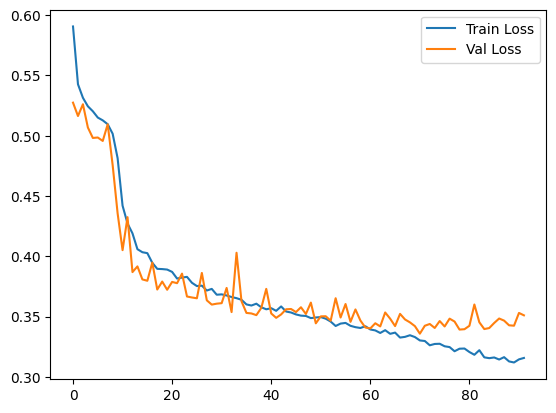

In [24]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

# 用测试集评分

In [26]:
test_dataset = MIMICDataset(test_listfile_path, mode='test')

[MIMICDataset] Loaded 4689 samples into memory.


In [27]:
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0, drop_last=True)

In [29]:
def test_model(model, test_dataloader, checkpoint_path, device='cuda'):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for timeseries, note_embeddings, labels in tqdm(test_dataloader, desc="Testing"):
            timeseries = timeseries.to(device)
            note_embeddings = note_embeddings.to(device)
            labels = labels.to(device)

            logits = model(timeseries, note_embeddings)
            preds = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # ==== 评估指标 ====
    auc = roc_auc_score(all_labels, all_preds)
    acc = accuracy_score(all_labels, (np.array(all_preds) >= 0.5).astype(int))
    print(f"✅ Test AUC: {auc:.4f}, Accuracy: {acc:.4f}")

    # ==== 绘制 AUC 曲线 ====
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve on Test Set")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Testing: 100%|██████████| 36/36 [00:00<00:00, 79.03it/s]

✅ Test AUC: 0.9095, Accuracy: 0.8318


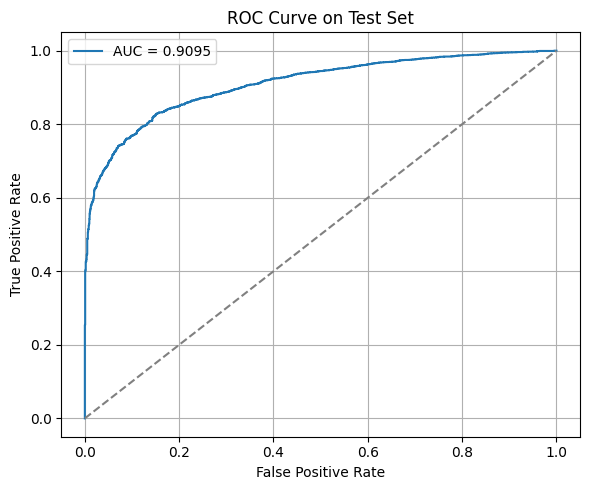

In [30]:
test_model(
    model,
    test_dataloader=test_dataloader,
    checkpoint_path='./saved_model/best_model.pth',
    device=device
)